In [25]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
def apiRunner():
  url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest' 
  #Original Sandbox Environment: 'https://sandbox-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
  API_KEY = "1c1d135a-1385-468b-bead-59720449dd9f"
  parameters = {
    'start':'1',
    'limit':'15',
    'convert':'USD'
  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY,
  }

  session = Session()
  session.headers.update(headers)

  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text) #dette er en syk dictionary
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
  
  return data

In [26]:
def getCurrencyInfo(currency, data):
    #currency = ex. "Bitcoin"
    #data = apirunner() // RAW-data fra APIet
    try:
        for info in data["data"]:
            if (info["name"] == currency):
                return info
    except KeyError:
        return "Could not find info for: ", currency, " error is: "

def getPrice(currency_info):
    #currency_info = RAW-data knyttet til én currency, som Bitcoin
    return currency_info["quote"]["USD"]["price"]

In [27]:
from time import sleep
from datetime import datetime

def populate_data_table(currency, intervall, numberOfRuns):
    timestampPrice = {}
    previousTimestamp= None

    if (intervall<1):
        raise ValueError("intervall for calling the APIrunner must be over 1 second")
    if (numberOfRuns<1):
        raise ValueError("you must perform at least 1 run of the APIrunner")


    
    for i in range(numberOfRuns):
        data = apiRunner()
        currencyInfo = getCurrencyInfo(currency, data)
        price = getPrice(currencyInfo)

        
        timestamp = datetime.now()
        #timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")

        if previousTimestamp is not None and timestamp == previousTimestamp:
            raise ValueError("We have two identical timestamps, meaning the API pull is too slow. Try increasing your interval")

        timestampPrice[timestamp]=price
        previousTimestamp=timestamp

        sleep(intervall)

    return timestampPrice

In [28]:
import datetime
import json
import os

def saveData(currency_info, currency):
    #currency_info = {datetime.datetime : price}
    #currency = ex: "Bitcoin"

    historical = readData(currency=currency)
    data_formatted = {}

    if (historical is not None):
        for key in list(historical.keys()):
            key_formatted = datetime.datetime.isoformat(key)
            data_formatted[key_formatted] = historical[key]

    for key_c in list(currency_info.keys()):
        key_formatted = datetime.datetime.isoformat(key_c)
        data_formatted[key_formatted] = currency_info[key_c]



    data_to_save = {
        currency: data_formatted
    }

    with open("data.json", "w") as json_file:
        json.dump(data_to_save, json_file)

def readData(currency):
    #currency = ex: "Bitcoin"

    if (os.path.getsize("data.json") ==0):
        print("data.json er tom!")
        return None
    
    with open ("data.json", "r") as json_file:
        data = json.load(json_file)

    if currency not in data.keys():
        raise ValueError("fant ikke: ", currency, "fra data.json arkivte")
    
    data_currency = data[currency]
    
    #reformaterer data_formatted til data pga backwardscompatability
    data_currency_unformatted = {}
    for key in data_currency.keys():
        key_unformatted = datetime.datetime.fromisoformat(key)
        data_currency_unformatted[key_unformatted] = data_currency[key]

    return data_currency_unformatted
    #return {datetime.datetime : price}
    

In [29]:
import matplotlib.pyplot as plt

def plotPrice(timestampPrice, currency):
    #timestampPrice = {datetime.datetime : price}
    #currency = ex: "Bitcoin"

    x_axis = []
    y_axis = list(timestampPrice.values())

    timestamps = list(timestampPrice.keys())
    intervall = timestamps[1] - timestamps[0]
    intervall_seconds = intervall.total_seconds()
    
    if (intervall_seconds//(60*60*24)>=1):
        intervall_string="days"
        # for i in range(len(y_axis)):
        #     x_axis.append(i*intervall_seconds//(60*60*24))
        x_axis = list(timestampPrice.keys())
    elif(intervall_seconds//(60*60)>=1):
        intervall_string="hours"
        # for i in range(len(y_axis)):
        #     x_axis.append(i*intervall_seconds//(60*60))
        x_axis = list(timestampPrice.keys())
    else:
        intervall_string="seconds"
        # for i in range(len(y_axis)):
        #     x_axis.append(i*intervall_seconds)
        x_axis = list(timestampPrice.keys())


    plt.plot(x_axis, y_axis, label=("current prise: ", price), color="blue")
    plt.title(("time VS price: ", currency))
    plt.grid(True)
    plt.xlabel(intervall_string)
    plt.ylabel("price")

    plt.legend()
    plt.show()



In [30]:
# from time import sleep
# from datetime import datetime

# def continous_plotting(currency, intervall, numberOfRuns):
#     timestampPrice = {}
#     previousTimestamp= None

#     if (intervall<1):
#         raise ValueError("intervall for calling the APIrunner must be over 1 second")
#     if (numberOfRuns<1):
#         raise ValueError("you must perform at least 1 run of the APIrunner")


#     for i in range(numberOfRuns):
#         data = apiRunner()
#         currencyInfo = getCurrency(currency, data)
#         price = getPrice(currencyInfo)
        
#         timestamp = datetime.now()

#         if previousTimestamp is not None and timestamp == previousTimestamp:
#             raise ValueError("We have two identical timestamps, meaning the API pull is too slow. Try increasing your interval")

#         timestampPrice[timestamp]=price
#         previousTimestamp=timestamp

#         if (i>=2):
#             plotPrice(timestampPrice=timestampPrice, currency=currency)
            
#         sleep(intervall)


In [31]:

from time import sleep
from datetime import datetime

def continous_save_data(currency, intervall, numberOfRuns):
    #currency = ex: "Bitcoin"
    #intervall = ex: 5 // number of seconds to wait between each apiPull
    #numberOfRund = ex: 10 // number of times we are to call apiPull

    #get previous data
    timestampPrice = readData(currency=currency)
    previousTimestamp= None

    if (intervall<1):
        raise ValueError("intervall for calling the APIrunner must be over 1 second")
    if (numberOfRuns<1):
        raise ValueError("you must perform at least 1 run of the APIrunner")


    for i in range(numberOfRuns):
        data = apiRunner()
        currencyInfo = getCurrencyInfo(currency, data)
        price = getPrice(currencyInfo)
        timestamp = datetime.now()
        #timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S.%f")

        if previousTimestamp is not None and timestamp == previousTimestamp:
            raise ValueError("We have two identical timestamps, meaning the API pull is too slow. Try increasing your interval")

        timestampPrice[timestamp]=price
        saveData(data=timestampPrice, currency=currency)
        previousTimestamp=timestamp
            
        sleep(intervall)


In [32]:
import matplotlib.pyplot as plt

def plot_moving_average(data_to_plot, intervall, period, currency):
    #data_to_plot = {datetime.datetime : price}
    #intervall = ex. 5 //how many measurements should each average consist of
    #period = ex. 5 // at least how many seconds should there be between each measurement
    #currency = ex "Bitcoin"

    times = list(data_to_plot.keys())
    values = list(data_to_plot.values())

    print("times: ", times)
    print("values: ", values)

    label = currency + ": moving average " + str(period) + " seconds, intervall: " + str(intervall)

    plt.plot(times, values, label = label, color = "blue")
    plt.grid(True)
    plt.xlabel("times")
    plt.ylabel("moving average")

    plt.legend()
    plt.show()

In [33]:
def movingAverage(data, period, intervall):
    #data = {datetime.datetime : price}
    #period = over hvilke datapunkter skal vi finne MA, feks 30 sekunder, 1 dag, 1 time, osv
    #intervall = hvor mange periods tar vi per beregning, feks en 5x1_dag moving average, osv

    times = list(data.keys())
    prices = list(data.values())

    #finner de datapunktene vi skal bruke
    moving_average = {}
    i=-1
    while(i<len(times)-1):
        i = i+1
        t0 = times[i]

        j=i+1
        while(j<len(times)-1):
            t1 = times[j]

            time_difference = abs( (t1-t0).total_seconds() )
            if (time_difference>=period):
                moving_average[times[i]] = prices[i]
                moving_average[times[j]] = prices[j]

                i = j-1
                break

            j += 1


    #konstruerer en ny moving average der verdiene er gjennomsnittene ved de forskjellige tidspunktene
    if (intervall > len(list(moving_average.keys()))):
        raise ValueError("Intervallet: ", intervall, " er lengre enn tiljengelig data!")
    
    moving_average_averages = {}
    times = list(moving_average.keys())
    prices = list(moving_average.values())

    for i in range(len(times)-intervall +1):

        to_compute = []
        j = i
        while (j<=i+intervall-1):
            to_compute.append(times[j])
            j += 1

        average = 0
        for k in range(intervall):
            average += moving_average[to_compute[k]]

        average = average / intervall
        moving_average_averages[times[i]] = average

    return(moving_average_averages)

{datetime.datetime(2023, 10, 9, 12, 0): 15.0, datetime.datetime(2023, 10, 9, 12, 0, 30): 25.0, datetime.datetime(2023, 10, 9, 12, 1): 35.0, datetime.datetime(2023, 10, 9, 12, 1, 30): 45.0, datetime.datetime(2023, 10, 9, 12, 2): 55.0, datetime.datetime(2023, 10, 9, 12, 2, 30): 65.0, datetime.datetime(2023, 10, 9, 12, 3): 75.0, datetime.datetime(2023, 10, 9, 12, 3, 30): 85.0}
times:  [datetime.datetime(2023, 10, 9, 12, 0), datetime.datetime(2023, 10, 9, 12, 0, 30), datetime.datetime(2023, 10, 9, 12, 1), datetime.datetime(2023, 10, 9, 12, 1, 30), datetime.datetime(2023, 10, 9, 12, 2), datetime.datetime(2023, 10, 9, 12, 2, 30), datetime.datetime(2023, 10, 9, 12, 3), datetime.datetime(2023, 10, 9, 12, 3, 30)]
values:  [15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0]


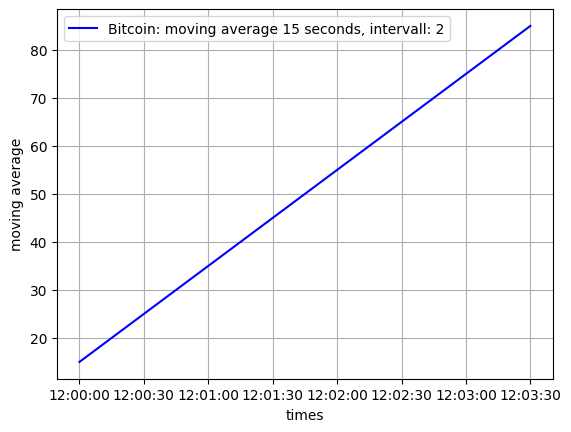

In [38]:
#TESTDATA
#lager falsk data for å teste movign average
import datetime

t1 = datetime.datetime(2023, 10, 9, 12, 0, 0 )
t2 = datetime.datetime(2023, 10, 9, 12, 0, 30 )
t3 = datetime.datetime(2023, 10, 9, 12, 1, 0 )
t4 = datetime.datetime(2023, 10, 9, 12, 1, 30 )
t5 = datetime.datetime(2023, 10, 9, 12, 2, 0 )
t6 = datetime.datetime(2023, 10, 9, 12, 2, 30 )
t7 = datetime.datetime(2023, 10, 9, 12, 3, 0 )
t8 = datetime.datetime(2023, 10, 9, 12, 3, 30 )
t9 = datetime.datetime(2023, 10, 9, 12, 4, 0 )
t10 = datetime.datetime(2023, 10, 9, 12, 4, 30 )
times = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]

prices = [10,20,30,40,50,60,70, 80, 90, 100]

data = {}
for i in range(len(times)):
    data[times[i]] = prices[i]

MA = movingAverage(data=data, period=30, intervall=2)
print(MA)
plot_moving_average(data_to_plot=MA, intervall=2, period=15, currency="Bitcoin")

In [39]:
import datetime

def continous_plotting_moving_average(currency, intervall, period, numberOfRuns):
    #numberOfRuns = how many times do you want to run this method
    #intervall = ex. 5 //how many measurements should each average consist of
    #period = ex. 5 // at least how many seconds should there be between each measurement
    #currency = ex "Bitcoin"

    historical = readData(currency=currency)


    if (len(list(historical.keys())) < intervall+1):
        for i in range(intervall+1):
            data = apiRunner()
            currecy_info = getCurrencyInfo(currency=currency, data=data)
            price = getPrice(currency_info=currecy_info)
            
            data_to_save = {}
            data_to_save[datetime.datetime.now()] = price
            saveData(currency_info=data_to_save, currency=currency)

            sleep(period)


    for i in range(numberOfRuns):
        #getting necesary data
        data = apiRunner()
        currency_info = getCurrencyInfo(currency=currency, data=data)
        price = getPrice(currency_info=currency_info)

        currency_info = {}
        currency_info[datetime.datetime.now()] = price

        #saving data
        saveData(currency_info=currency_info, currency=currency)

        #reading all data
        all_data = readData(currency=currency)

        #plotting moving avwerage
        moving_average = movingAverage(data=all_data, period=period, intervall=intervall)
        plot_moving_average(data_to_plot=moving_average, intervall=intervall, period=period, currency=currency)

        #putting system to sleep
        sleep(period)

In [35]:
def delete_all_data():
    with open ("data.json", "w") as json_file:
        pass

data.json er tom!
times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690)]
values:  [26896.279411209962, 26896.052751438157]


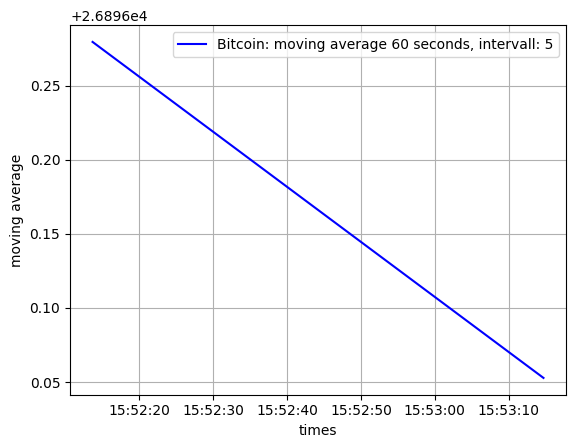

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975]


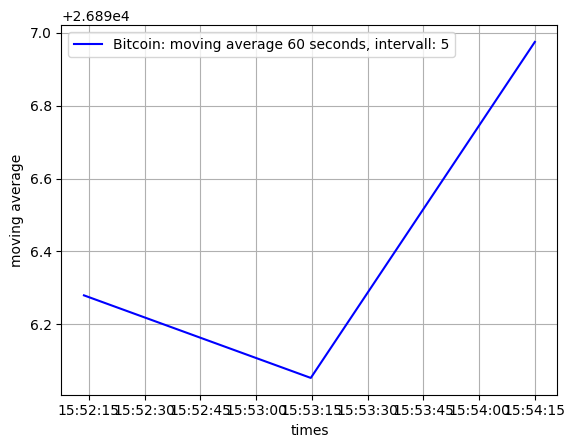

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583]


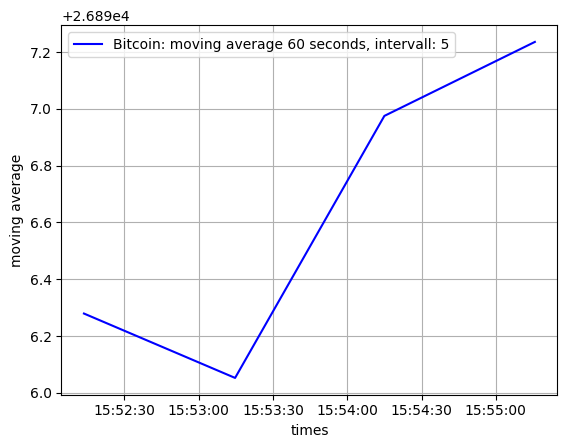

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872]


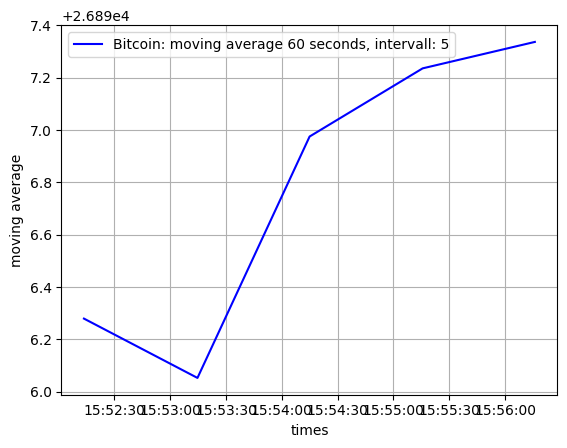

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887]


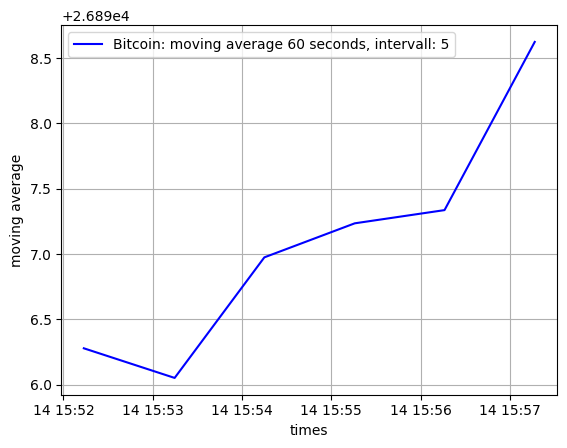

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639]


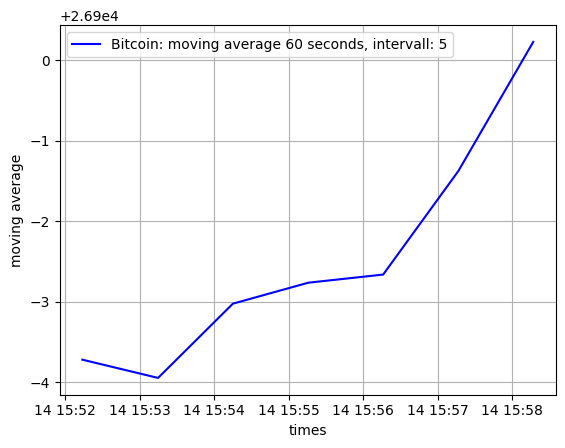

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813]


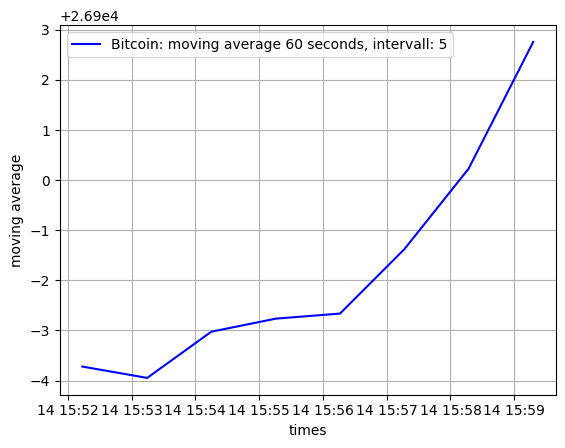

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685]


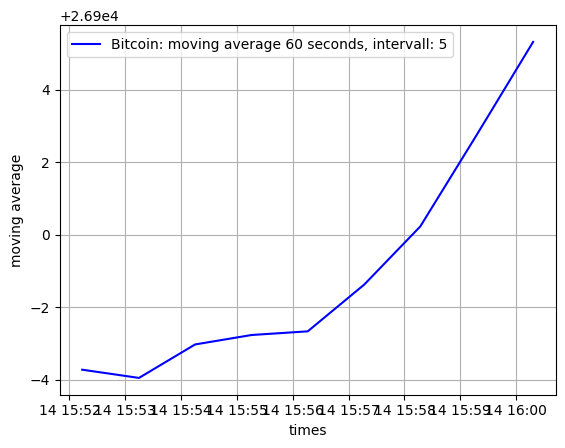

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685, 26907.379065657227]


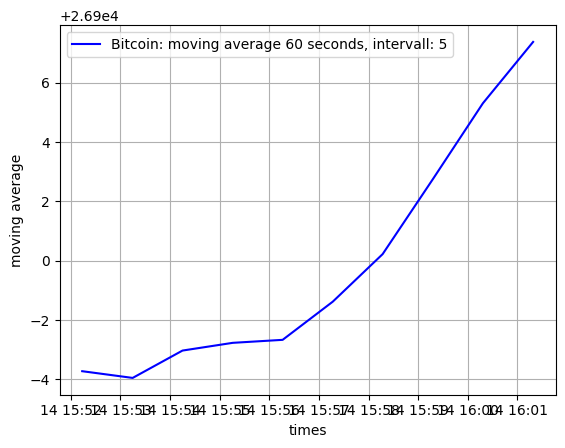

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685, 26907.379065657227, 26907.987272975133]


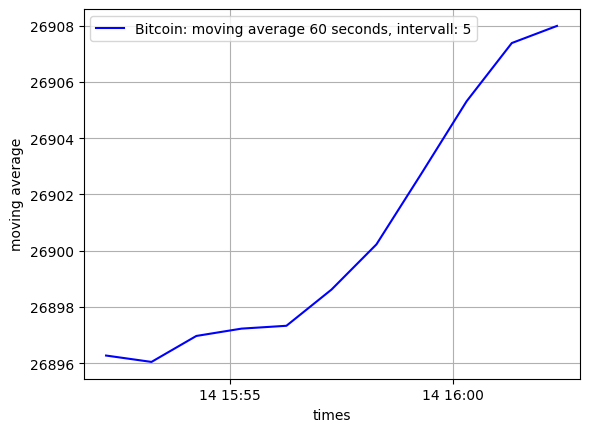

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685, 26907.379065657227, 26907.987272975133, 26907.823342568205]


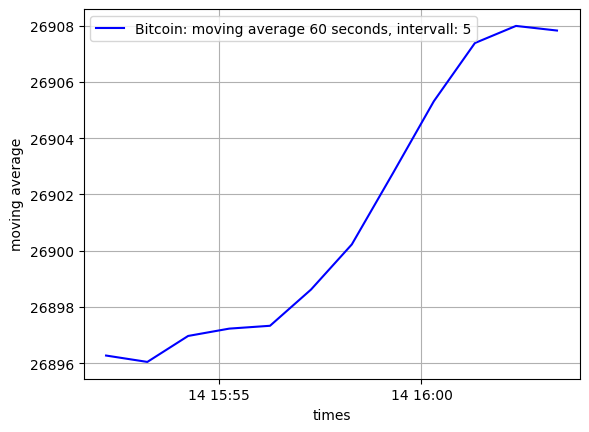

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685, 26907.379065657227, 26907.987272975133, 26907.823342568205, 26906.73711722521]


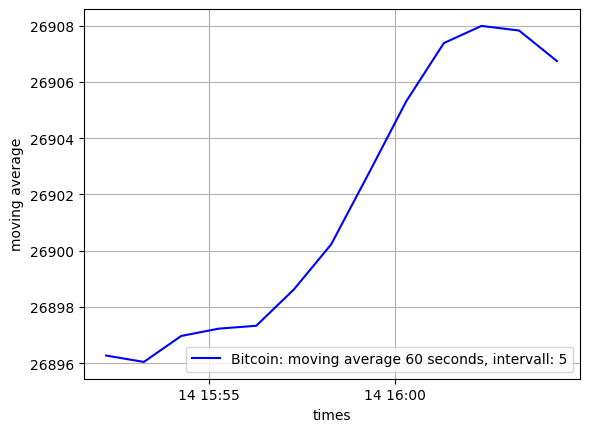

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685, 26907.379065657227, 26907.987272975133, 26907.823342568205, 26906.737117

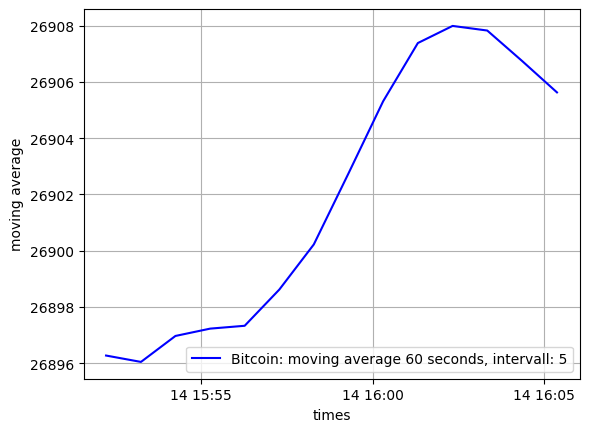

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.75662496813, 26905.311714676685, 26907.379065657227, 

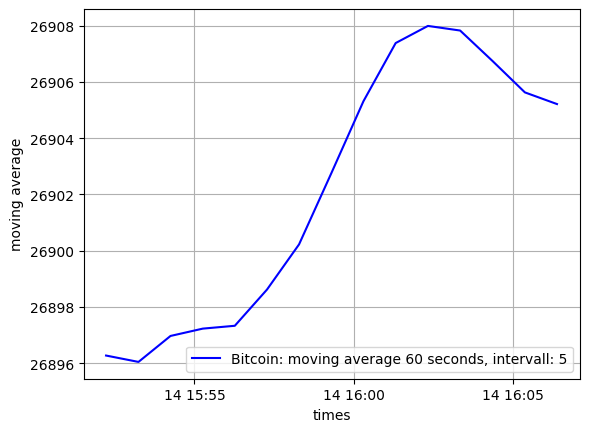

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.336502558872, 26898.62321520887, 26900.22633501639, 26902.7

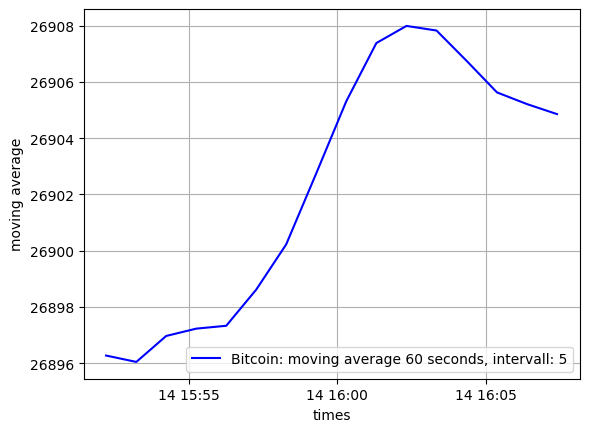

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133)]
values:  [26896.279411209962, 26896.052751438157, 26896.975064814975, 26897.235487464583, 26897.3365025

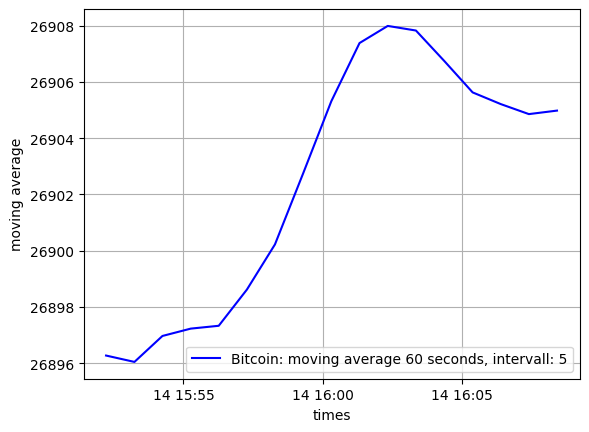

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788)]
values:  [26896.279411209962, 26896.052751438157, 2

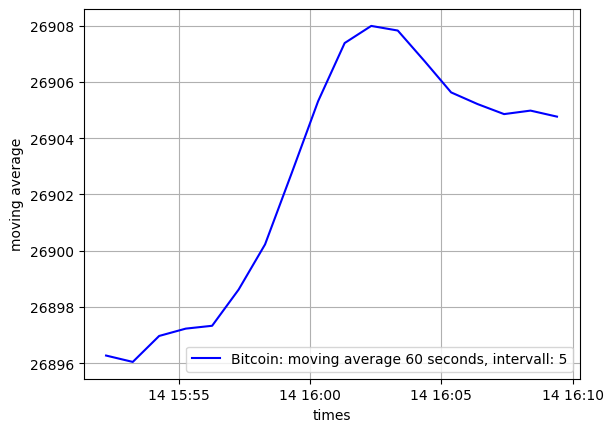

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

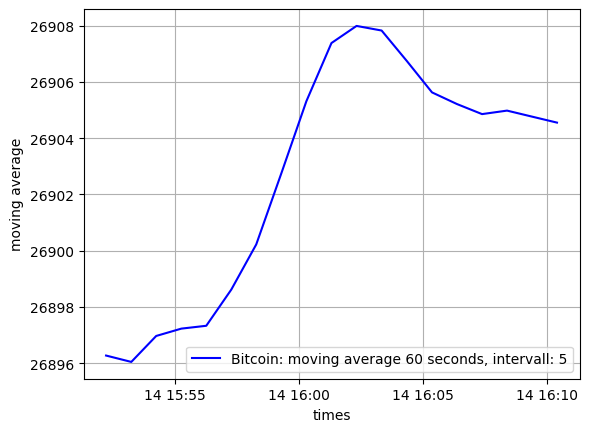

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

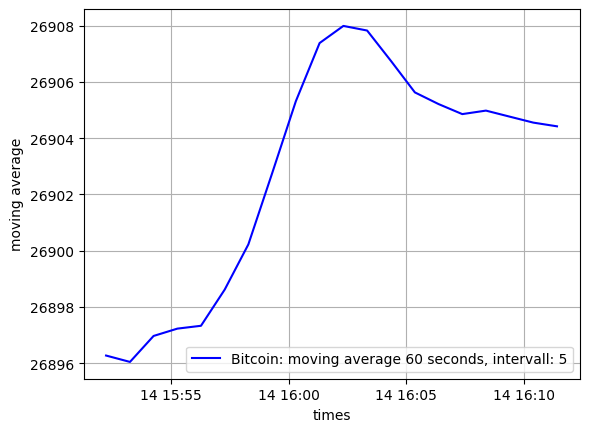

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

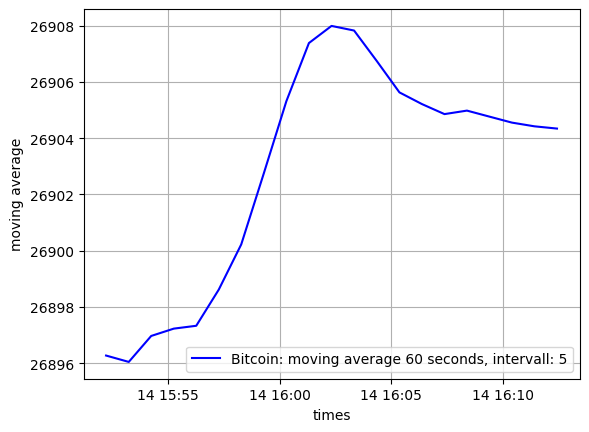

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

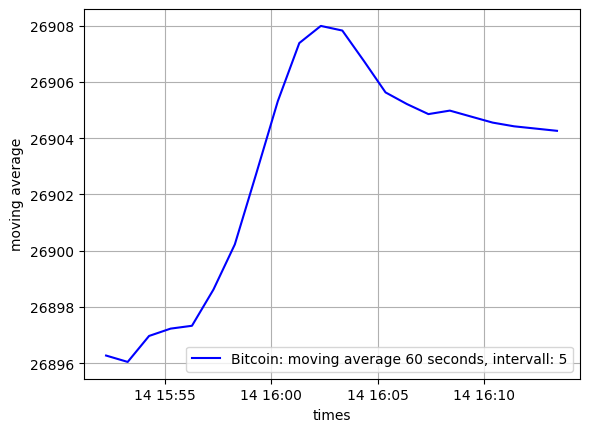

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

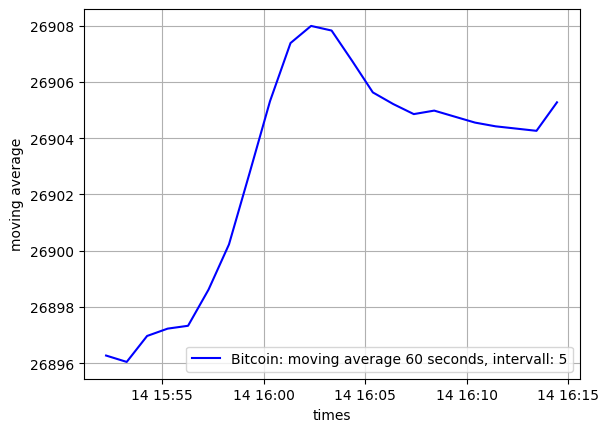

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

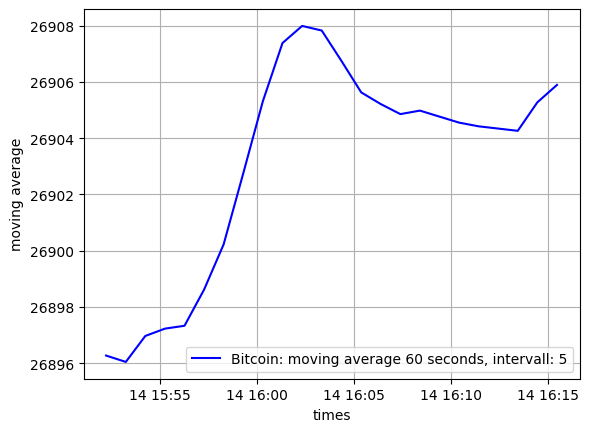

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

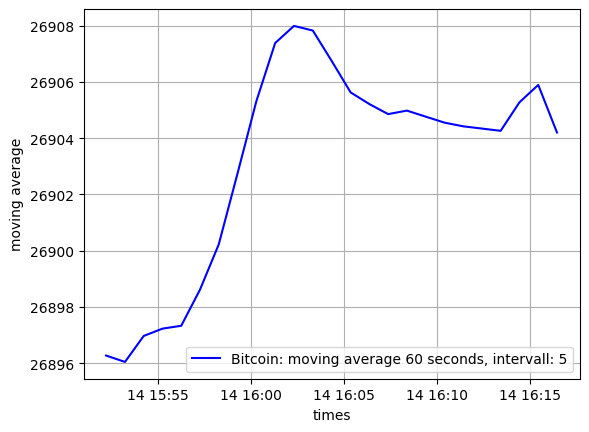

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

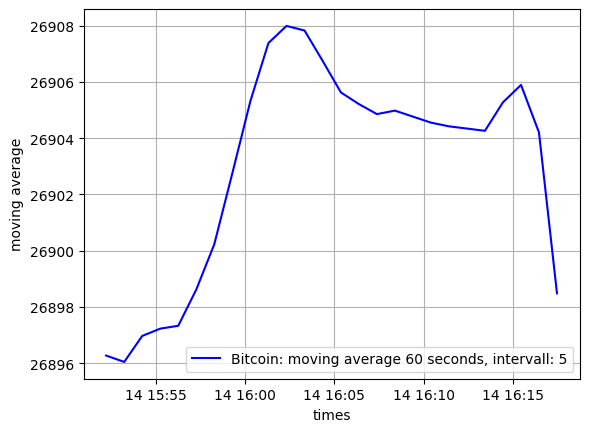

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

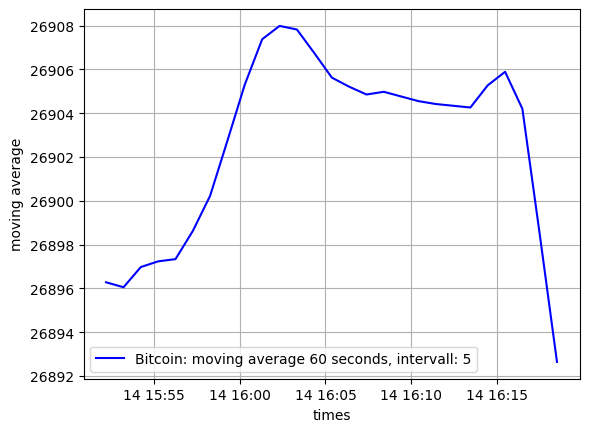

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

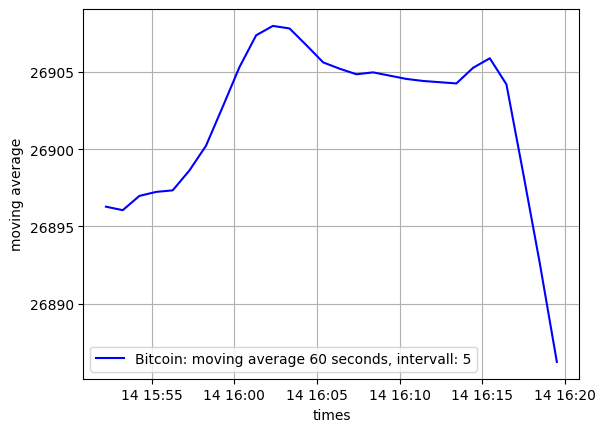

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

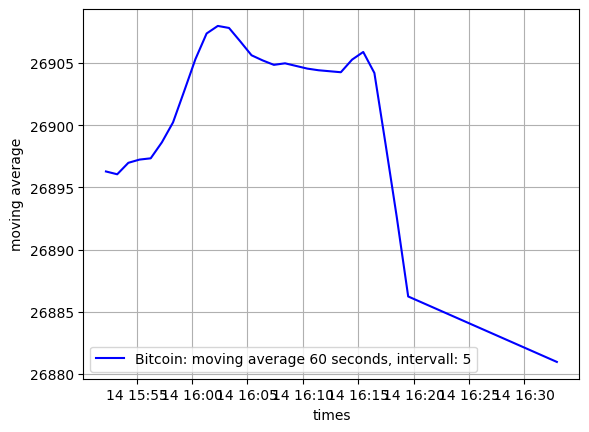

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

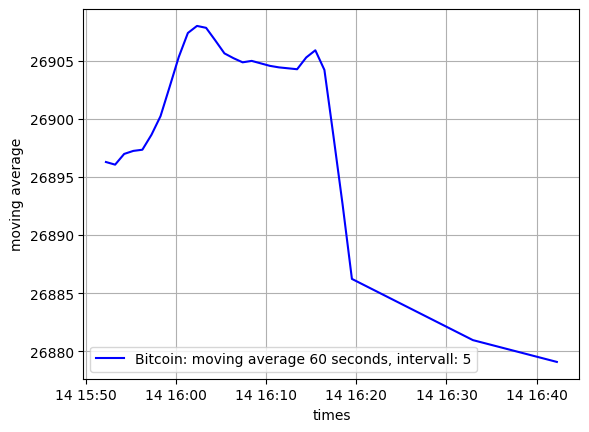

times:  [datetime.datetime(2023, 10, 14, 15, 52, 13, 687835), datetime.datetime(2023, 10, 14, 15, 53, 14, 712690), datetime.datetime(2023, 10, 14, 15, 54, 14, 990226), datetime.datetime(2023, 10, 14, 15, 55, 15, 751568), datetime.datetime(2023, 10, 14, 15, 56, 16, 68386), datetime.datetime(2023, 10, 14, 15, 57, 16, 688067), datetime.datetime(2023, 10, 14, 15, 58, 17, 574), datetime.datetime(2023, 10, 14, 15, 59, 17, 820472), datetime.datetime(2023, 10, 14, 16, 0, 18, 260685), datetime.datetime(2023, 10, 14, 16, 1, 18, 962252), datetime.datetime(2023, 10, 14, 16, 2, 19, 684666), datetime.datetime(2023, 10, 14, 16, 3, 20, 327464), datetime.datetime(2023, 10, 14, 16, 4, 21, 539697), datetime.datetime(2023, 10, 14, 16, 5, 22, 267078), datetime.datetime(2023, 10, 14, 16, 6, 22, 668877), datetime.datetime(2023, 10, 14, 16, 7, 23, 301967), datetime.datetime(2023, 10, 14, 16, 8, 23, 747133), datetime.datetime(2023, 10, 14, 16, 9, 24, 208788), datetime.datetime(2023, 10, 14, 16, 10, 24, 579099)

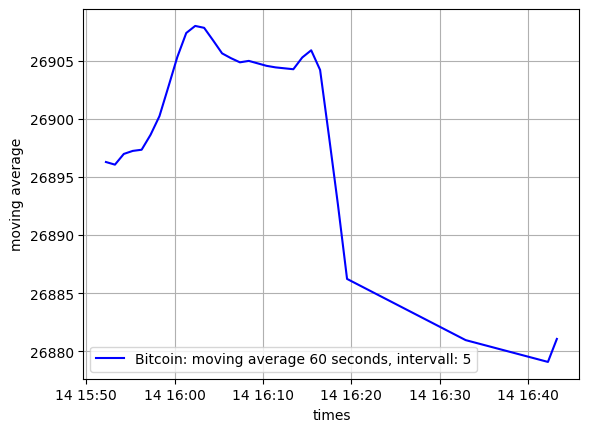

In [41]:
delete_all_data()

data = apiRunner()
currency_info = {datetime.datetime.now() : getPrice(currency_info=getCurrencyInfo(currency="Bitcoin", data=data)) }
saveData(currency_info=currency_info, currency="Bitcoin")

continous_plotting_moving_average(currency="Bitcoin", intervall=5, period=60, numberOfRuns=30)

In [ ]:
# #TESTDATA
# #lager falsk data for å teste movign average
# import datetime

# t1 = datetime.datetime(2023, 10, 9, 12, 0, 0 )
# t2 = datetime.datetime(2023, 10, 9, 12, 0, 30 )
# t3 = datetime.datetime(2023, 10, 9, 12, 1, 0 )
# t4 = datetime.datetime(2023, 10, 9, 12, 1, 30 )
# t5 = datetime.datetime(2023, 10, 9, 12, 2, 0 )
# t6 = datetime.datetime(2023, 10, 9, 12, 2, 30 )
# t7 = datetime.datetime(2023, 10, 9, 12, 3, 0 )
# t8 = datetime.datetime(2023, 10, 9, 12, 3, 30 )
# t9 = datetime.datetime(2023, 10, 9, 12, 4, 0 )
# t10 = datetime.datetime(2023, 10, 9, 12, 4, 30 )
# times = [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]

# prices = [10,20,30,40,50,60,70, 80, 90, 100]

# data = {}
# for i in range(len(times)):
#     data[times[i]] = prices[i]

# MA = movingAverage(data=data, period=30, intervall=2)
# print(MA)
# plot_moving_average(data_to_plot=MA, intervall=2, period=15, currency="Bitcoin")